In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Coil import Coil as Coil
from Coil import transform_to_spatial_domain as transform_to_spatial_domain
import matplotlib_setup as mlp_setup
import matplotlib.font_manager
import numpy.matlib


mlp_setup.mpl_setup()

# Optimal coil design
We consider measurements of the translating fluxmeter, which allows to scan the flux distribution in the $x,z$-plane.<br>
The flux linked with the coils area at positon $\mathbf{r}=(x,y,z)^T$ is given by:
$$
\Phi(x,y,z) = \sum_{i=1}^I \int_{x'=x-w_i/2}^{x+w_i/2} \int_{z'=z-l_i/2}^{z+l_i/2}B_y(x',y,z')\, \mathrm{d}z'\, \mathrm{d}x'
$$
where $I$ is the number of coil turns with lenght $l_i$ and width $w_i$.

In this notebook we focus on the optimal coil design in terms of of $w_i$ and $l_i$.

## Univariate field reconstruction
Assuming homogenity over $x$ the flux linkage reduces to:
$$
\Phi(x,y,z) = \sum_{i=1}^I w_i\int_{z'=z-l_i/2}^{z+l_i/2}B_y(x,y,z')\, \mathrm{d}z'
$$


The challenge is now to reconstruct $B_y(x,y,z)$ for fixed $x$, $y$ over $z$. To do so, we expand $B_y(z)$ in a suitable basis:
$$
B_y(z) = \sum_{k=1}^K c_k \psi_k(z).
$$

Of spectial interest is the fourier basis:
$$
B_y(z) = \sum_{k=-K}^K c_k \exp\left(-2\pi j k \frac{z}{L}\right).
$$

Because it follows from the general solution of the Laplace equation.

A flux measurement relates to the expansion coefficients $c_k$ by:
$$
\Phi(x,y,z) = \sum_{k=-K}^K c_k\sum_{i=1}^I w_i\int_{z'=z-l_i/2}^{z+l_i/2}\exp\left(-2\pi j k \frac{z'}{L}\right)\, \mathrm{d}z'
$$


The integration over $z$ can lead to a so called ''blind eye'' of the sensor towards frequency compintents with $f = 1/l_i$.<br>
Consider for instance the coil in the upcoming figure:

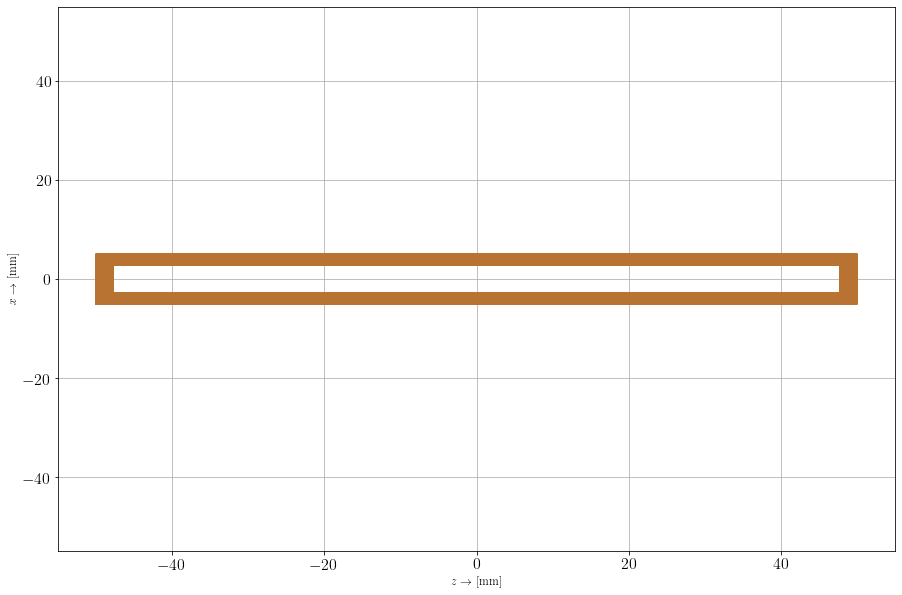

In [2]:
radius = 1.
l_0 = 100e-3
w_0 = 10e-3
track_width = 0.2e-3
num_turns = 12

lens_l = np.array([l_0-k*2*track_width for k in range(num_turns)])
widths_l = np.array([w_0-k*2*track_width for k in range(num_turns)])

coil_l = Coil(radius,1,lens_l,widths_l,np.ones(widths_l.shape))
coil_l.plot_layout()

This sensor has a length of $~100$ mm. The tracks are wound closely to each other to maximise the overall coil area and thus the sensitiviy.<br>
Note that however the outer and inner length of the coil is given by:

In [3]:
print('Outer length = {} mm'.format(max(lens_l)*1000))
print('Inner length = {} mm'.format(min(lens_l)*1000))

Outer length = 100.0 mm
Inner length = 95.60000000000001 mm


Leading to a ''blurring'' of frequency components of $f \sim 1/100$ 1/mm in the fluxmeters response.
We define the effective coil length by:
$$
l_e = \frac{\mathrm{max}(l_i)+\mathrm{min}(l_i)}{2}
$$

In [4]:
l_e = 0.5*(max(lens_l)+min(lens_l))
print('l_e = {} mm'.format(l_e*1000))

l_e = 97.8 mm


We can express this effect in numbers by looking at the condition number of the matrix $\mathbf{D}^T\mathbf{D}$ with the design matrix:
$$
[\mathbf{D}]_{m,k} = \sum_{i=1}^I w_i\int_{z'=z_m-l_i/2}^{z_m+l_i/2}\exp\left(-2\pi j k \frac{z'-Z_0}{Z_1-Z_0}\right)\, \mathrm{d}z'.
$$

The background here is that solution $\mathbf{c}$ with:
$$
\mathbf{D}^T\mathbf{D}\mathbf{c} = \mathbf{D}^T \pmb{\Phi}
$$
yields the least squares solution for the coefficients $\mathbf{c}=(c_{-K},...,c_{K})^T$.

Increasing $K$ in our expansion means including higher and higher frequency components. So lets have a look the condition number $\mathrm{cond}(\mathbf{D}^T\mathbf{D})$ over K, for the coild we have plotted above.

Note that the integration in $[\mathbf{D}]_{m,k}$ can be done analytically, since:
$$
\int_{z'=z_m-l_i/2}^{z_m+l_i/2}\exp\left(-2\pi j k \frac{z'-Z_0}{Z_1-Z_0}\right)\, \mathrm{d}z' = \frac{Z_1-Z_0}{-2\pi j k}\left[\exp\left(-2\pi j k \frac{z'-Z_0}{Z_1-Z_0}\right)\right]_{z_m - l_i/2}^{z_m+l_i/2}
$$

$$
\frac{Z_1-Z_0}{-2\pi j k}\left[\exp\left(-2\pi j k \frac{z'-Z_0}{Z_1-Z_0}\right)\right]_{z_m - l_i/2}^{z_m+l_i/2} = \frac{Z_1-Z_0}{-2\pi j k}\left[\exp\left(-2\pi j k \frac{(z_m+l_i/2)-Z_0}{Z_1-Z_0}\right)-\exp\left(-2\pi j k \frac{(z_m-l_i/2)-Z_0}{Z_1-Z_0}\right) \right] 
$$

$$
\frac{Z_1-Z_0}{-2\pi j k}\left[\exp\left(-2\pi j k \frac{(z_m+l_i/2)-Z_0}{Z_1-Z_0}\right)-\exp\left(-2\pi j k \frac{(z_m-l_i/2)-Z_0}{Z_1-Z_0}\right) \right] = \frac{Z_1-Z_0}{-2\pi j k}\exp\left(-2\pi j k \frac{z_m-Z_0}{Z_1-Z_0}\right)\left[\exp\left(-2\pi j k \frac{l_i/2}{Z_1-Z_0}\right)-\exp\left(-2\pi j k \frac{-l_i/2}{Z_1-Z_0}\right) \right] 
$$

$$
= \frac{Z_1-Z_0}{-2\pi j k}\exp\left(-2\pi j k \frac{z_m-Z_0}{Z_1-Z_0}\right)(-2j)\sin\left(2\pi k \frac{l_i/2}{Z_1-Z_0}\right)
$$

$$
= \frac{Z_1-Z_0}{\pi k}\exp\left(-2\pi j k \frac{z_m-Z_0}{Z_1-Z_0}\right)\sin\left(2\pi k \frac{l_i/2}{Z_1-Z_0}\right)
$$

In [5]:
max_K = 100

L = 1.
num_z = 1000
z = np.linspace(0.,L,num_z)-L/2
Z_0 = min(z)
Z_1 = max(z)
dz = z[1]-z[0]

cond_container_l = np.zeros((max_K-5,2))

for KK in range(5,max_K):
    D = coil_l.assemble_D_fluxmeter_fourier_univariate(z,KK)
    cond_container_l[KK-5,1] = np.linalg.cond(D)
    cond_container_l[KK-5,0] = KK
    

In [6]:
K_1 = 1/l_e/L

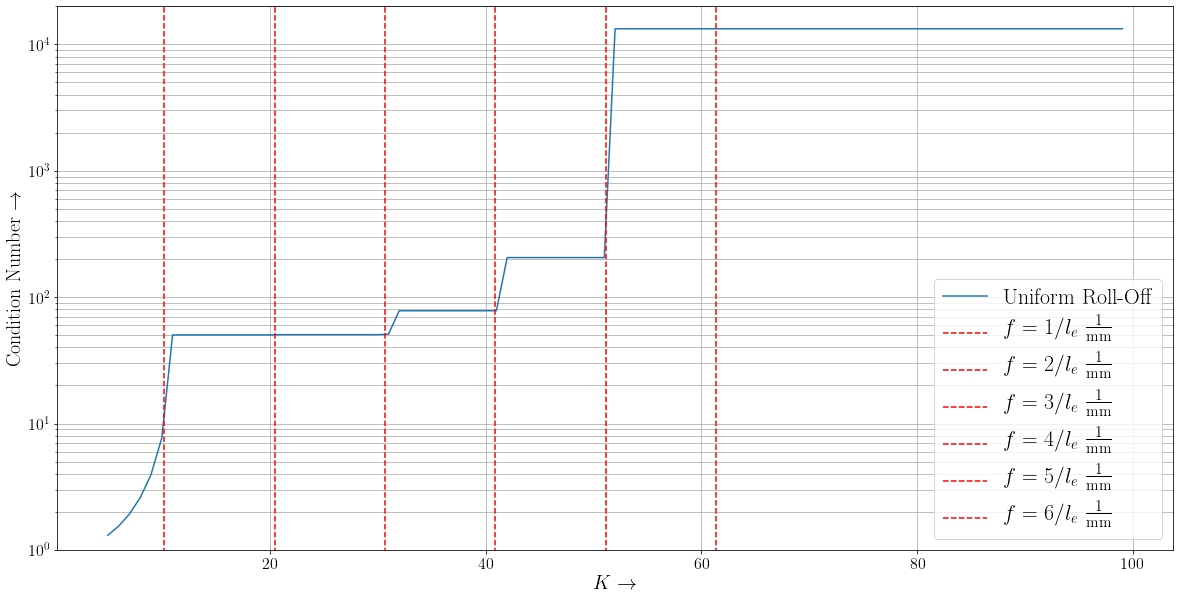

In [7]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(cond_container_l[:,0],cond_container_l[:,1],label='Uniform Roll-Off',linewidth=1.5)
ax.plot([K_1,K_1],[0,1e5],'--',color='r',label = r'$f = 1/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([2*K_1,2*K_1],[0,1e5],'--',color='r',label = r'$f = 2/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([3*K_1,3*K_1],[0,1e5],'--',color='r',label = r'$f = 3/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([4*K_1,4*K_1],[0,1e5],'--',color='r',label = r'$f = 4/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([5*K_1,5*K_1],[0,1e5],'--',color='r',label = r'$f = 5/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([6*K_1,6*K_1],[0,1e5],'--',color='r',label = r'$f = 6/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.set_xlabel(r'$K\rightarrow$',fontsize=20)
ax.set_ylabel(r'Condition Number $\rightarrow$',fontsize=20)
ax.set_yscale('log')
ax.set_ylim((1,2e4))
ax.legend()

Due to the blind eye, we obseve a jump in the condition number, whenever we pass a multiple of $f_e = 1/l_e$.

Interestingly we do not have these jumps for $K\approx 20$ and $K > 50$.

Let's generate some example signal and compute the least squares solution for different K.

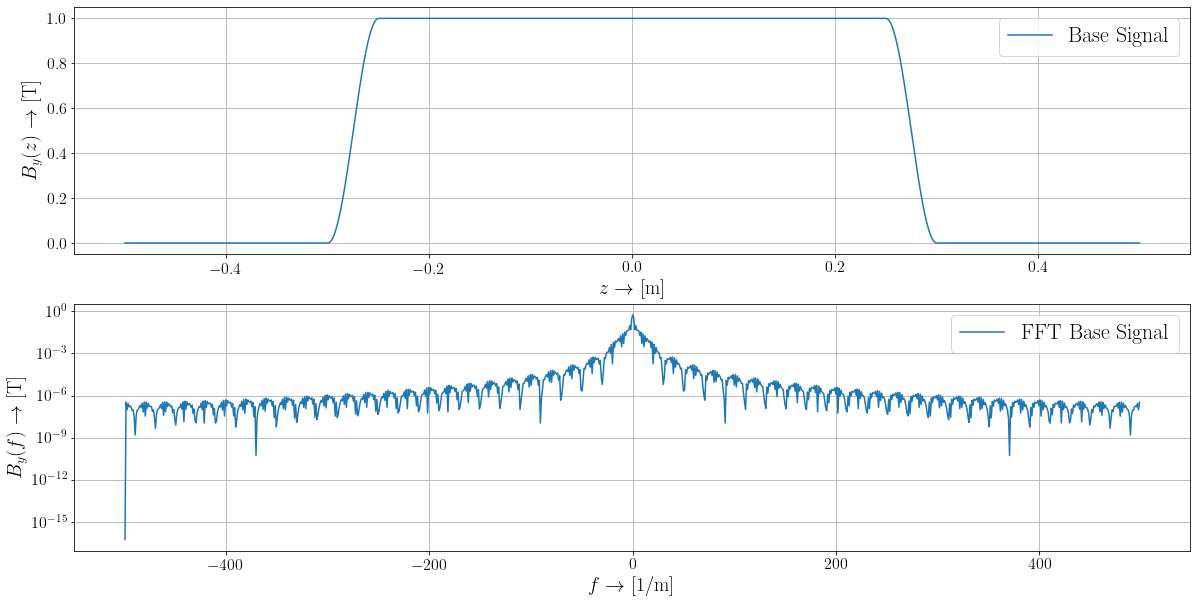

In [8]:
Z_pulse = 0.5
Z_ramp = 0.05

By_fcn = lambda x: 0.5*(np.cos(np.pi*(x+Z_pulse/2)/Z_ramp)+1)*(x<-Z_pulse/2)*(x>-Z_pulse/2-Z_ramp)+(x<Z_pulse/2)*(x>-Z_pulse/2) + 0.5*(np.cos(np.pi*(x-Z_pulse/2)/Z_ramp)+1)*(x>Z_pulse/2)*(x < Z_pulse/2 + Z_ramp)
base_signal = By_fcn(z) # 0.5*(np.cos(np.pi*(z+Z_pulse/2)/Z_ramp)+1)*(z<-Z_pulse/2)*(z>-Z_pulse/2-Z_ramp)+(z<Z_pulse/2)*(z>-Z_pulse/2) + 0.5*(np.cos(np.pi*(z-Z_pulse/2)/Z_ramp)+1)*(z>Z_pulse/2)*(z < Z_pulse/2 + Z_ramp)

fft_base = np.fft.fft(base_signal)/len(base_signal)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.plot(z,base_signal,label='Base Signal',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$B_y(z) \rightarrow$ [T]',fontsize=20)
ax.legend()
ax = fig.add_subplot(2,1,2)
ax.plot(np.fft.fftshift(np.fft.fftfreq(len(base_signal),dz)),np.fft.fftshift(abs(fft_base)),label='FFT Base Signal',linewidth=1.5)
ax.set_xlabel(r'$f\rightarrow$ [1/m]',fontsize=20)
ax.set_ylabel(r'$B_y(f) \rightarrow$ [T]',fontsize=20)
ax.set_yscale('log')
ax.legend()

C:\Users\meliebsc\cernbox\development\projects\fluxmeter\Coil.py:120: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  int_array[m] += self.widths[i]*integrate.quad(fcn, zz_m-l_2, zz_m+l_2)[0]


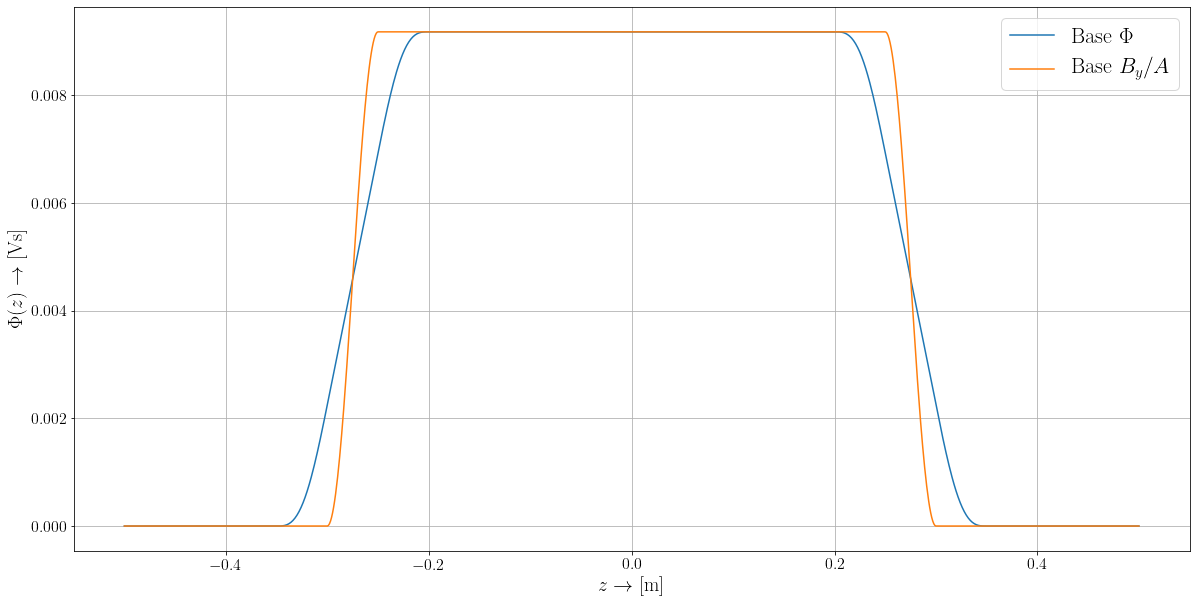

In [9]:
Phi = coil_l.integrate_z(By_fcn,z)
Phi_approx = base_signal*coil_l.compute_kn(1)


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(z,Phi,label='Base $\Phi$',linewidth=1.5)
ax.plot(z,Phi_approx,label='Base $B_y/A$',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()

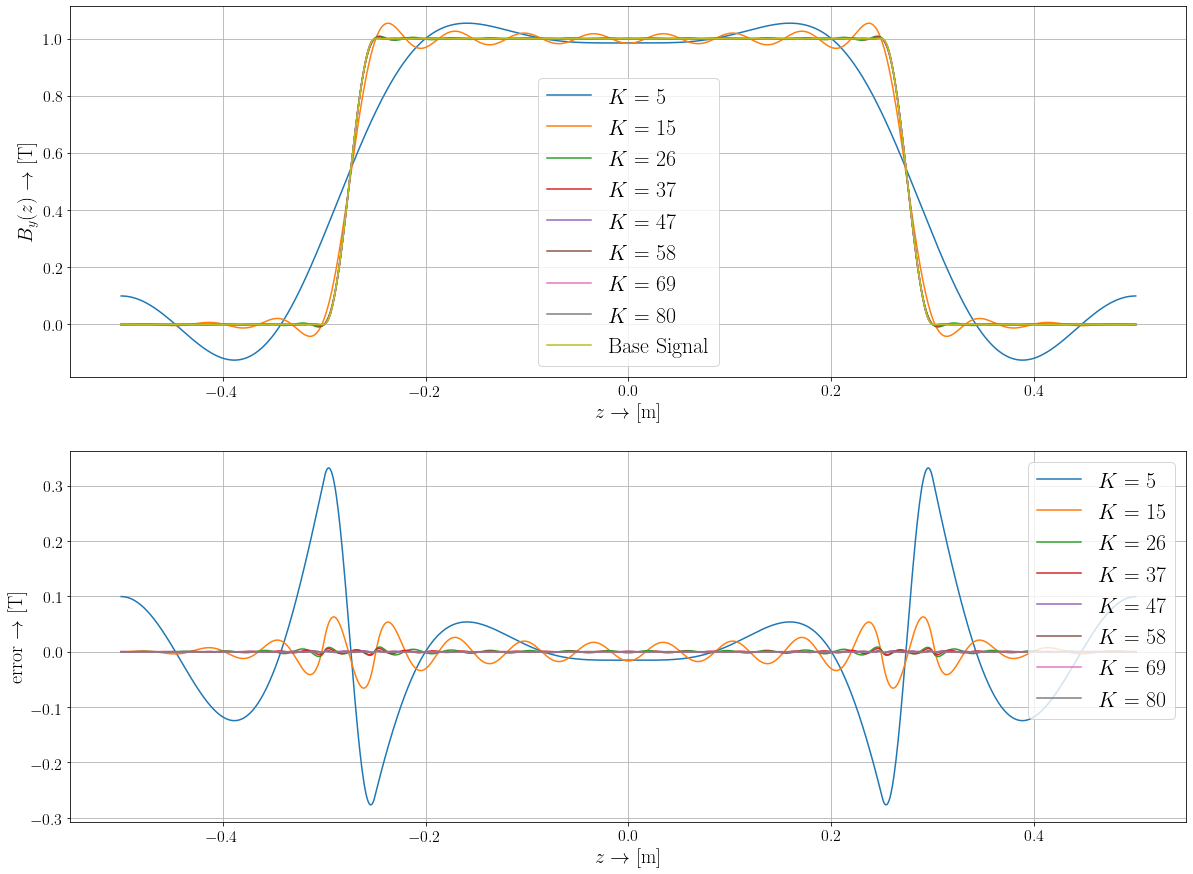

In [10]:
K_array = np.int32(np.linspace(5,80,8))
rms_container = np.zeros(K_array.shape)

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


for i,KK in enumerate(K_array):

    D = coil_l.assemble_D_fluxmeter_fourier_univariate(z,KK)
    c_k,_,_,_  = np.linalg.lstsq(D, Phi, rcond=None)
    
    By_rec = transform_to_spatial_domain(c_k,z,Z_0,Z_1)
    
    ax1.plot(z,np.real(By_rec),label=r'$K = {}$'.format(KK),linewidth=1.5)
    ax2.plot(z,np.real(By_rec)-base_signal,label=r'$K = {}$'.format(KK),linewidth=1.5)
    
    rms_container[i] = np.sqrt(np.mean((np.real(By_rec)-base_signal)**2))
    
ax1.plot(z,base_signal,label='Base Signal',linewidth=1.5)
ax1.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax1.set_ylabel(r'$B_y(z) \rightarrow$ [T]',fontsize=20)
ax1.legend()

ax2.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax2.set_ylabel(r'error $\rightarrow$ [T]',fontsize=20)
ax2.legend()

Text(0, 0.5, 'RMS $\\rightarrow$ [T]')

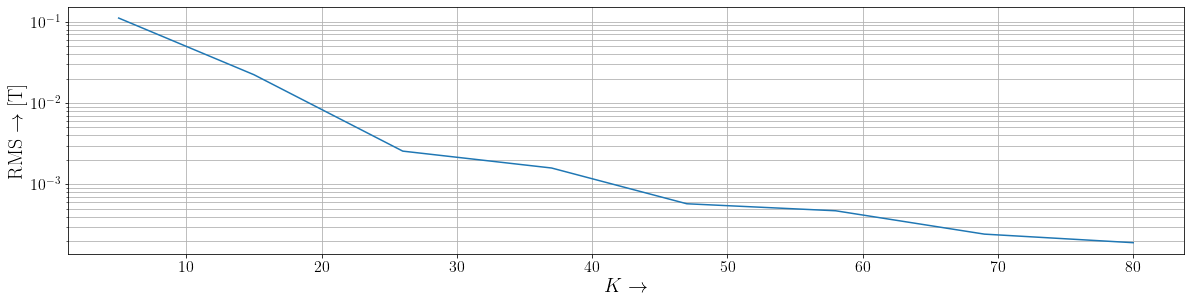

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.plot(K_array,rms_container,label=r'RMS Error',linewidth=1.5)
ax.set_yscale('log')
ax.set_xlabel(r'$K\rightarrow$',fontsize=20)
ax.set_ylabel(r'RMS $\rightarrow$ [T]',fontsize=20)

We take a closer look at the $K = 80$ solution:

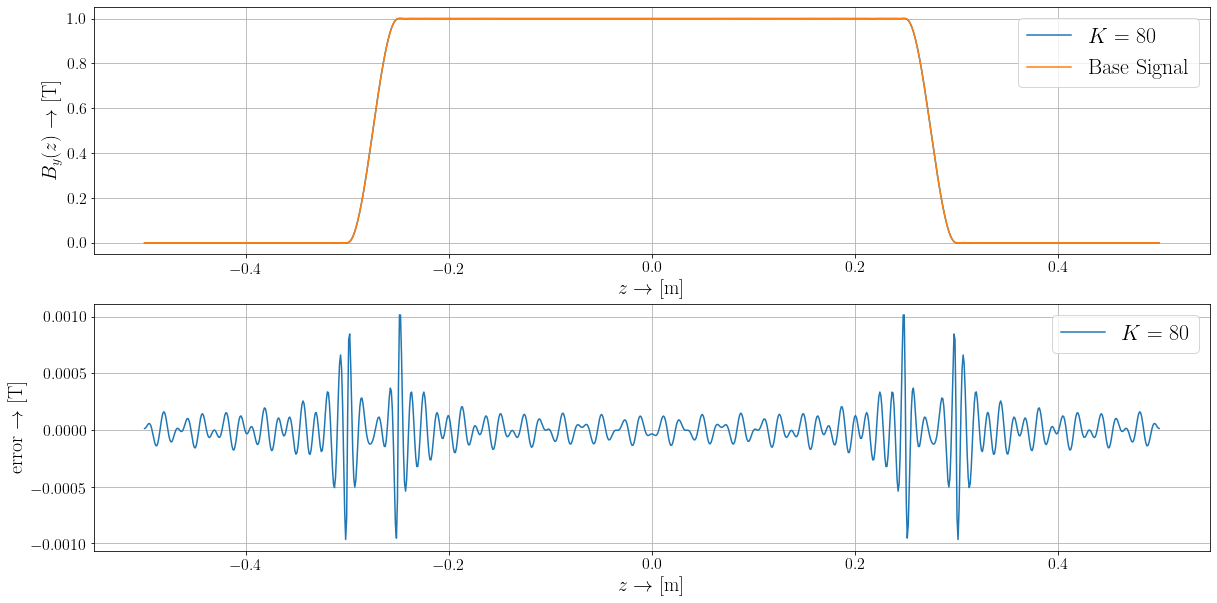

In [12]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


ax1.plot(z,np.real(By_rec),label=r'$K = {}$'.format(KK),linewidth=1.5)
ax2.plot(z,np.real(By_rec)-base_signal,label=r'$K = {}$'.format(KK),linewidth=1.5)
    
ax1.plot(z,base_signal,label='Base Signal',linewidth=1.5)
ax1.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax1.set_ylabel(r'$B_y(z) \rightarrow$ [T]',fontsize=20)
ax1.legend()

ax2.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax2.set_ylabel(r'error $\rightarrow$ [T]',fontsize=20)
ax2.legend()

The absolute error is below $1$ mT.

In this example, we considered the ground truth $\Phi(z)$ on the RHS of the equation system. In reality, the measurement data will suffer from systematic and random errors.<br>
We will now first account for random errors, by adding gaussian random noise with a small standard deviation of:
$$
\sigma = 1e^{-4}\mathrm{max}(\Phi)
$$

sigma = 9.176960000000002e-07 Vs


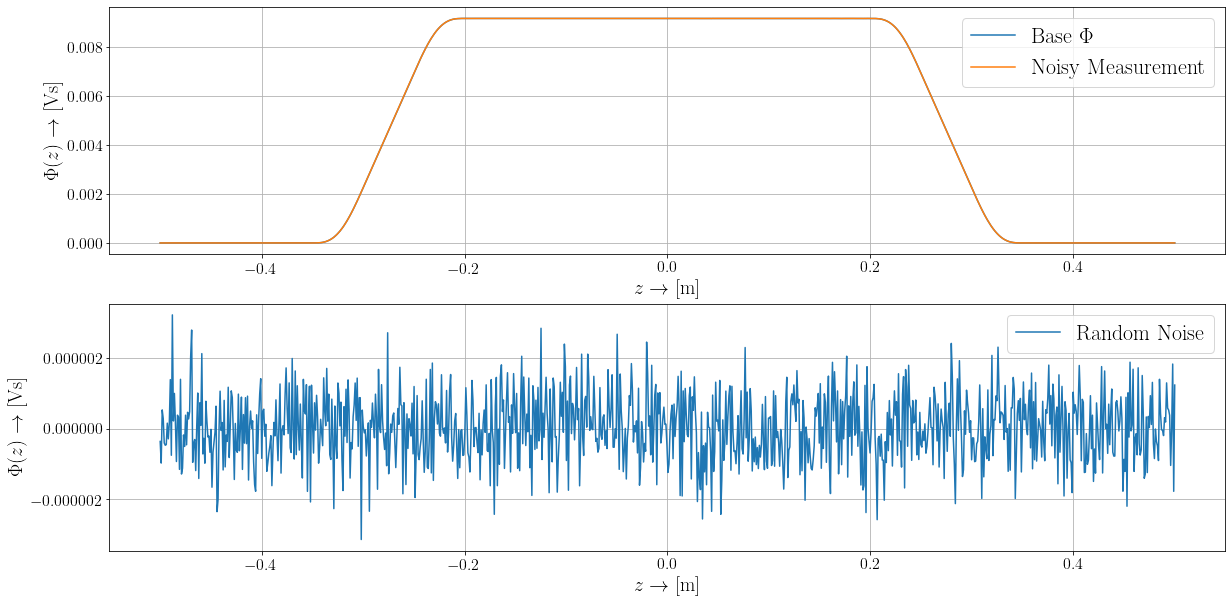

In [13]:
sigma = 1e-4*max(Phi)

Phi_n = Phi + sigma*np.random.randn(Phi.shape[0])

print('sigma = {} Vs'.format(sigma))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.plot(z,Phi,label='Base $\Phi$',linewidth=1.5)
ax.plot(z,Phi_n,label='Noisy Measurement',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()
ax = fig.add_subplot(2,1,2)
ax.plot(z,Phi_n-Phi,label='Random Noise',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()

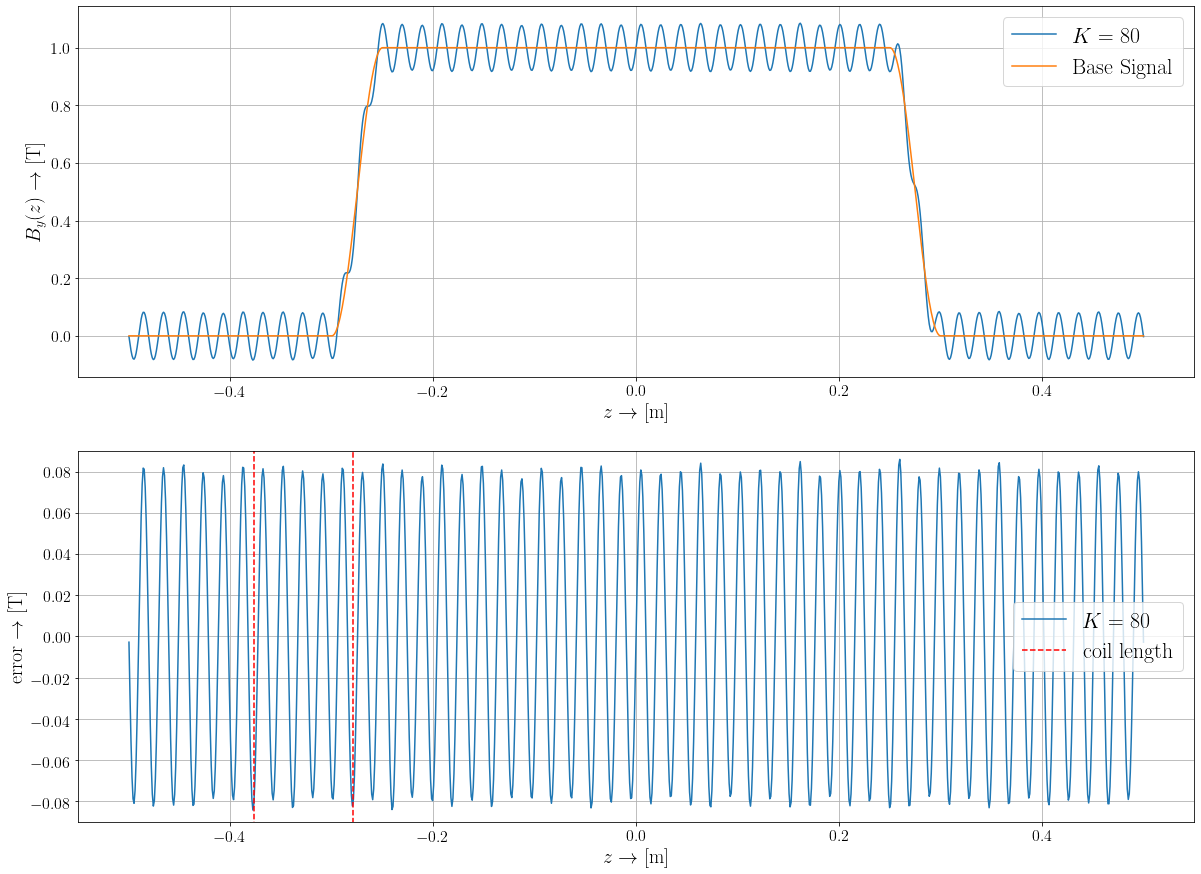

In [14]:
c_k,_,_,_  = np.linalg.lstsq(D, Phi_n, rcond=None)
By_rec = transform_to_spatial_domain(c_k,z,Z_0,Z_1)

error_l = np.real(By_rec)-base_signal

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(z,np.real(By_rec),label=r'$K = {}$'.format(80),linewidth=1.5)
ax2.plot(z,error_l,label=r'$K = {}$'.format(80),linewidth=1.5)

ax1.plot(z,base_signal,label='Base Signal',linewidth=1.5)
ax1.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax1.set_ylabel(r'$B_y(z) \rightarrow$ [T]',fontsize=20)
ax1.legend()

vzpos = -0.377
ax2.plot([vzpos,vzpos,vzpos+l_e,vzpos+l_e],[-100,100,100,-100],'--',color='red',label='coil length')
ax2.set_ylim((-0.09,0.09))
ax2.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax2.set_ylabel(r'error $\rightarrow$ [T]',fontsize=20)
ax2.legend()

Our reconstruction is highly affected by the noise contribution. Our approach is not robust to random errors.

The strongest oscillation we observe fits 5 times into the coil length, i.e. it has a frequency of:

In [15]:
print('f = {} 1/mm'.format(5/l_e/1000))

f = 0.051124744376278126 1/mm


Let's consider an alternative layout illustrated in the upcoming figure:

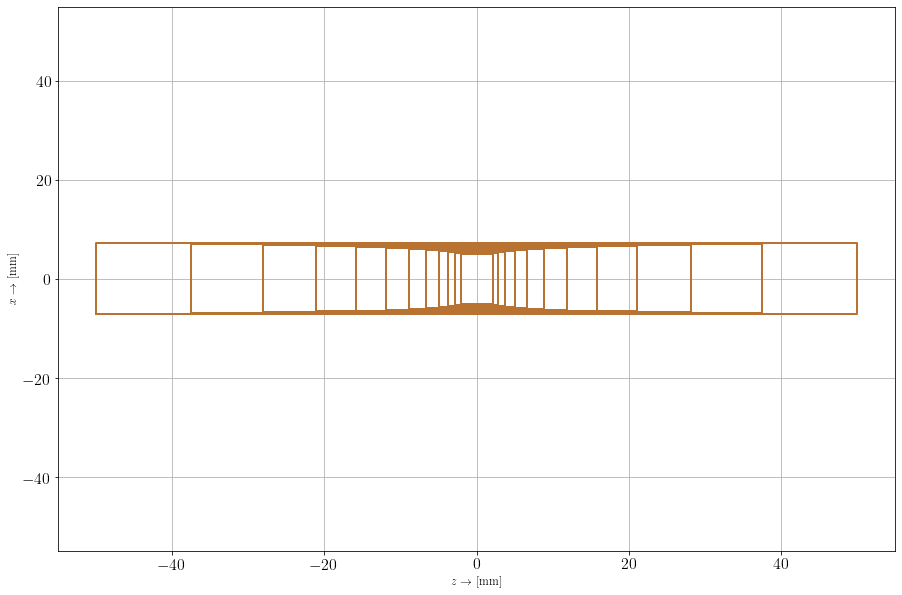

In [16]:
lens_g = np.array([(3/4)**k*l_0 for k in range(num_turns)])
widths_g = np.array([w_0+k*2*track_width for k in range(num_turns)])
widths_g = widths_g[-1::-1]

coil_g = Coil(radius,1,lens_g,widths_g,np.ones(widths_g.shape))
coil_g.plot_layout()

This coil has the same outer length but a graded roll-off.<br>
This graded roll-off can be expressed in terms of the winding length which is given by:
$$
l_{i+1} = \frac{3}{4} l_i 
$$

In this way, the length of winding $i+1$ is optimal with respect to the lowest frequency in the bline eye of winding $i$.<br>
Let's look at the resulting condition number:

In [17]:
cond_container_g = np.zeros((max_K-5,2))

for KK in range(5,max_K):
    D = coil_g.assemble_D_fluxmeter_fourier_univariate(z,KK)
    cond_container_g[KK-5,1] = np.linalg.cond(D)
    cond_container_g[KK-5,0] = KK

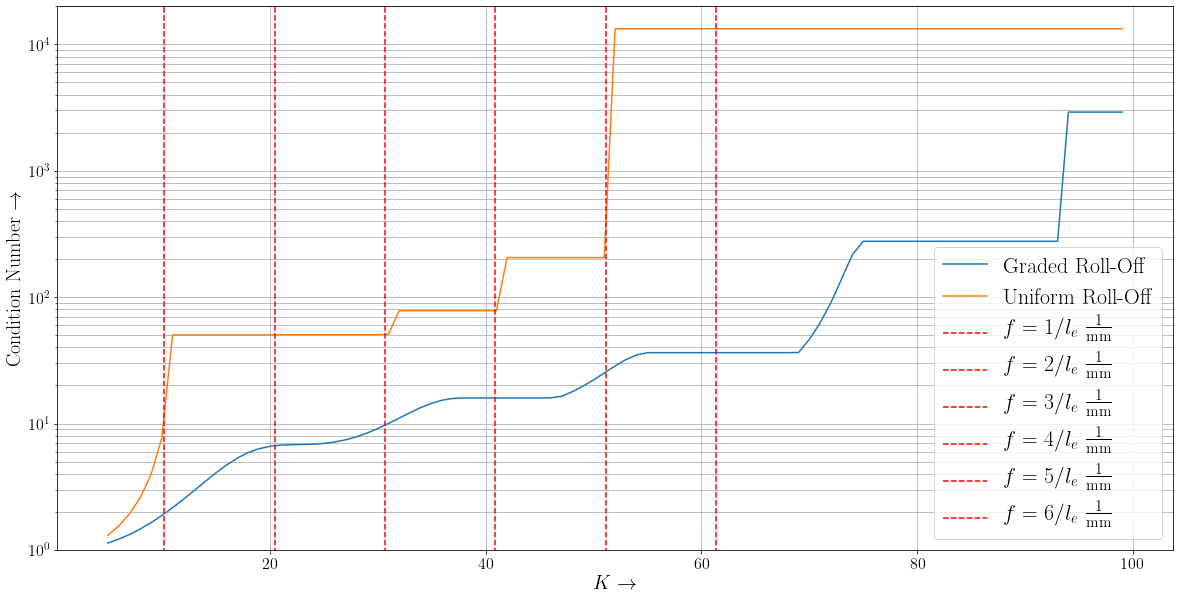

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(cond_container_g[:,0],cond_container_g[:,1],label='Graded Roll-Off',linewidth=1.5)
ax.plot(cond_container_l[:,0],cond_container_l[:,1],label='Uniform Roll-Off',linewidth=1.5)
ax.plot([K_1,K_1],[0,1e5],'--',color='r',label = r'$f = 1/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([2*K_1,2*K_1],[0,1e5],'--',color='r',label = r'$f = 2/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([3*K_1,3*K_1],[0,1e5],'--',color='r',label = r'$f = 3/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([4*K_1,4*K_1],[0,1e5],'--',color='r',label = r'$f = 4/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([5*K_1,5*K_1],[0,1e5],'--',color='r',label = r'$f = 5/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.plot([6*K_1,6*K_1],[0,1e5],'--',color='r',label = r'$f = 6/l_e$ $\frac{1}{\mathrm{mm}}$')
ax.set_xlabel(r'$K\rightarrow$',fontsize=20)
ax.set_ylabel(r'Condition Number $\rightarrow$',fontsize=20)
ax.set_yscale('log')
ax.set_ylim((1,2e4))
ax.legend()

The conditining of the equation system is improved by orders of magnitude.<br>
Note however, that we are loosing in sensitivity, since the overall coil area is decreased. <br>
TO DO: Derive this from $\mathbf{v}\times\mathbf{B}$. The Sensitivity is not increased in absolute value, but the length of maximum signal is shorter.

We now have a look how a flux measurement would look like in case of our graded roll-off sensor.

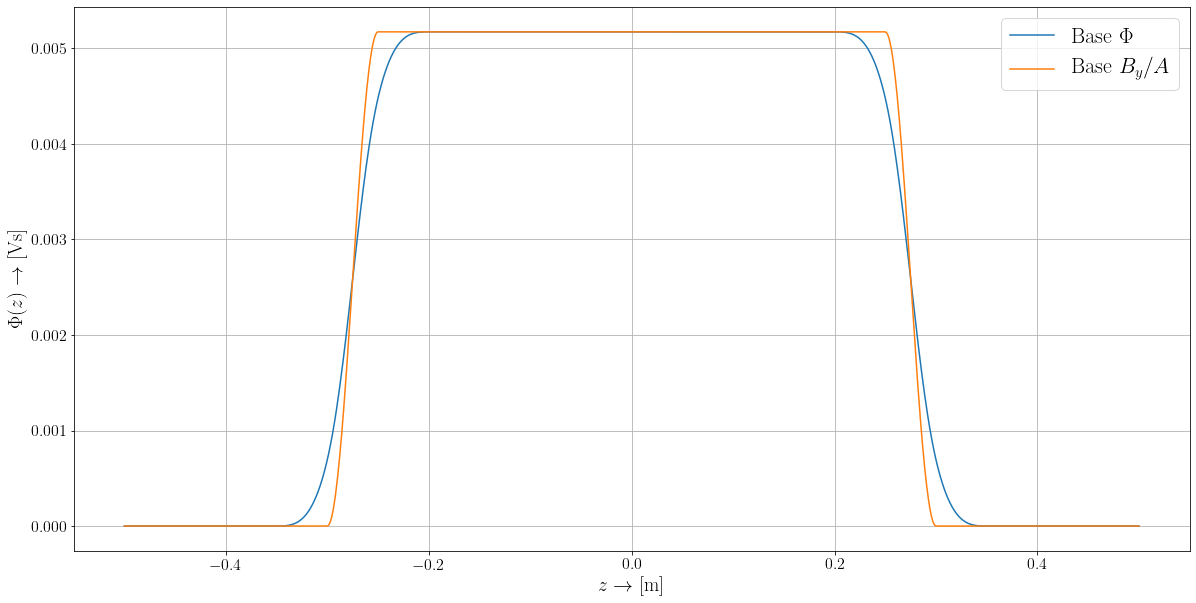

In [19]:
Phi = coil_g.integrate_z(By_fcn,z)
Phi_approx = base_signal*coil_g.compute_kn(1)


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(z,Phi,label='Base $\Phi$',linewidth=1.5)
ax.plot(z,Phi_approx,label='Base $B_y/A$',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()

And now use this $\Phi(z)$ signal for the extraction of the expansion coefficients. First, we again consider the noise free szenario:

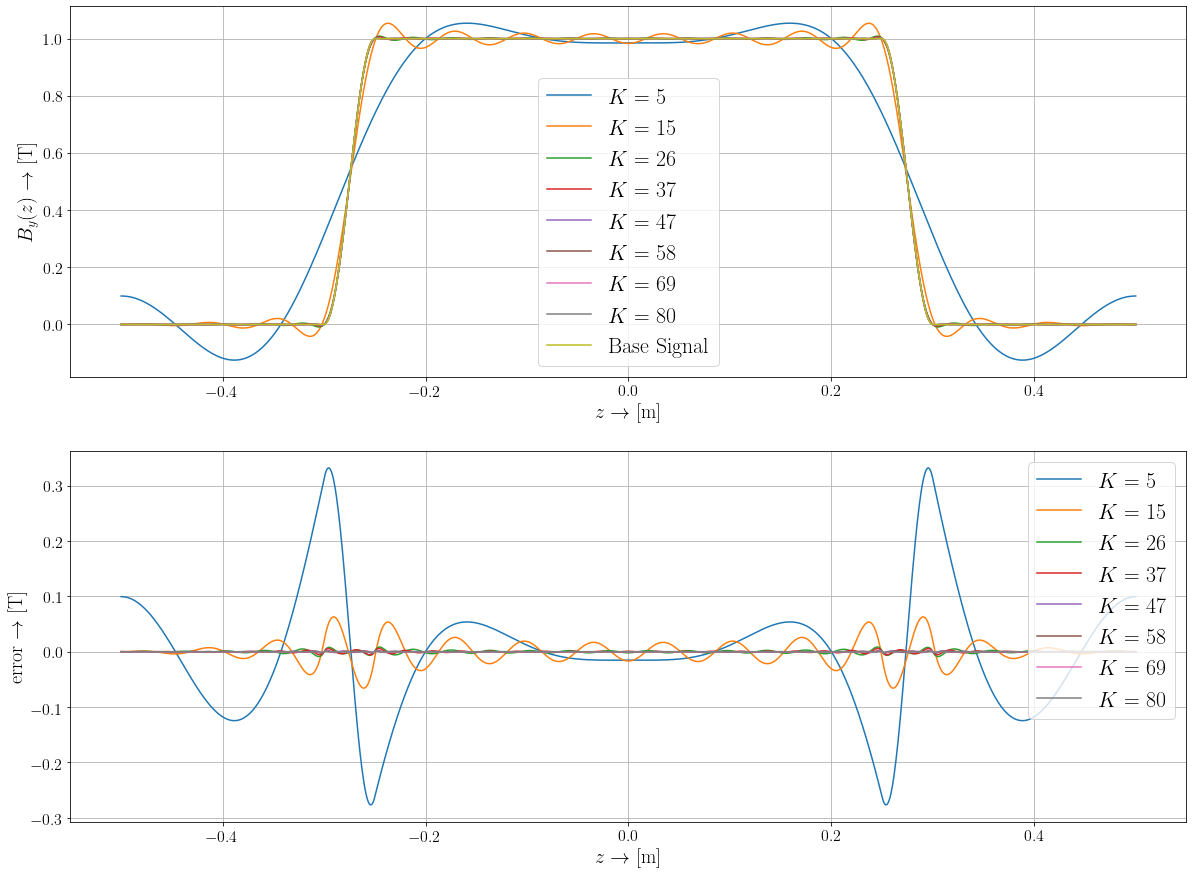

In [27]:
K_array = np.int32(np.linspace(5,80,8))
rms_container_g = np.zeros(K_array.shape)

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


for i,KK in enumerate(K_array):

    D = coil_g.assemble_D_fluxmeter_fourier_univariate(z,KK)
    c_k,_,_,_  = np.linalg.lstsq(D, Phi, rcond=None)
    
    By_rec = transform_to_spatial_domain(c_k,z,Z_0,Z_1)
    
    ax1.plot(z,np.real(By_rec),label=r'$K = {}$'.format(KK),linewidth=1.5)
    ax2.plot(z,np.real(By_rec)-base_signal,label=r'$K = {}$'.format(KK),linewidth=1.5)
    
    rms_container_g[i] = np.sqrt(np.mean((np.real(By_rec)-base_signal)**2))
    
ax1.plot(z,base_signal,label='Base Signal',linewidth=1.5)
ax1.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax1.set_ylabel(r'$B_y(z) \rightarrow$ [T]',fontsize=20)
ax1.legend()

ax2.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax2.set_ylabel(r'error $\rightarrow$ [T]',fontsize=20)
ax2.legend()

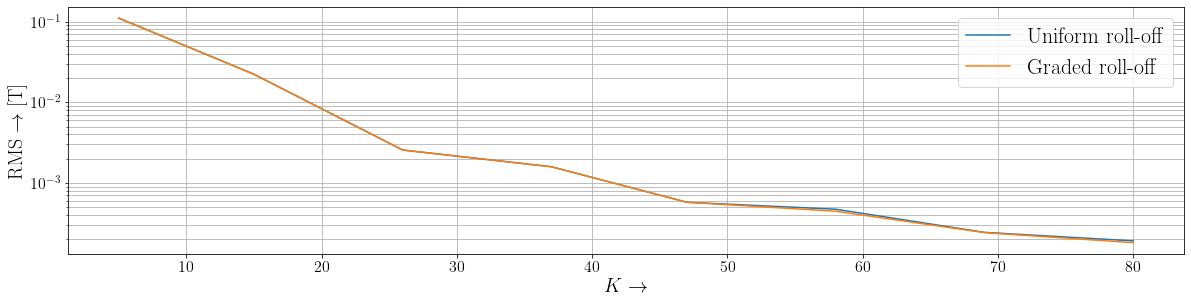

In [28]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.plot(K_array,rms_container,label=r'Uniform roll-off',linewidth=1.5)
ax.plot(K_array,rms_container_g,label=r'Graded roll-off',linewidth=1.5)
ax.set_yscale('log')
ax.set_xlabel(r'$K\rightarrow$',fontsize=20)
ax.set_ylabel(r'RMS $\rightarrow$ [T]',fontsize=20)
ax.legend()

In the noise free szenario we dont see much of a difference.<br>
Now let's add noise with the same standard deviation we have used before.

sigma = 9.176960000000002e-07 Vs


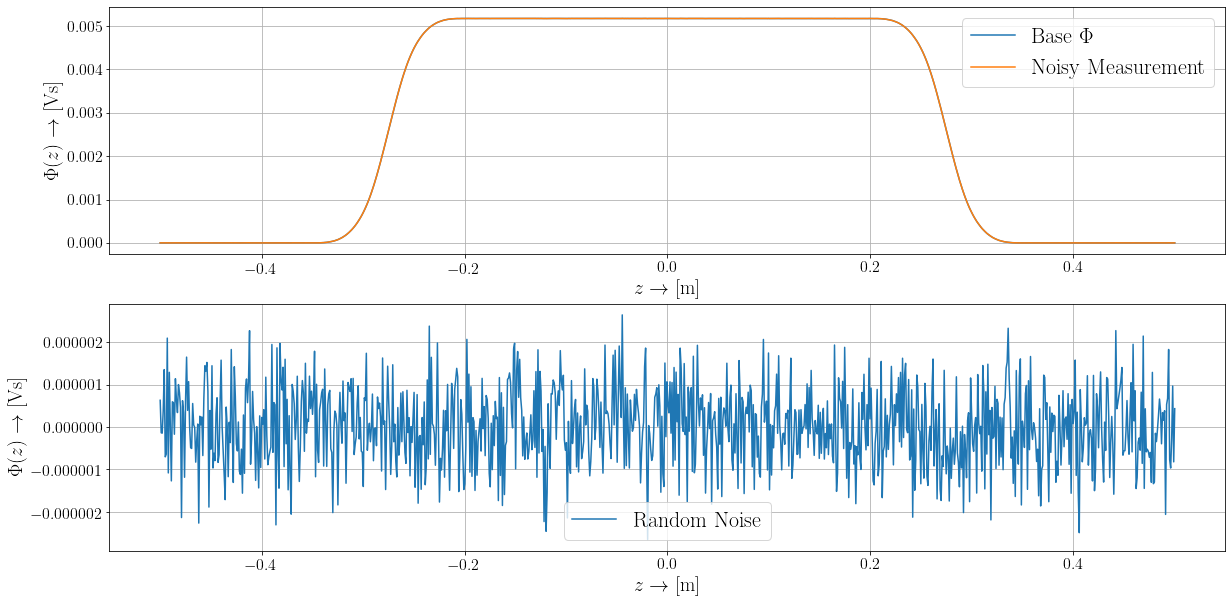

In [68]:
Phi_n = Phi + sigma*np.random.randn(Phi.shape[0])

print('sigma = {} Vs'.format(sigma))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.plot(z,Phi,label='Base $\Phi$',linewidth=1.5)
ax.plot(z,Phi_n,label='Noisy Measurement',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()
ax = fig.add_subplot(2,1,2)
ax.plot(z,Phi_n-Phi,label='Random Noise',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()

We then comute the coefficients for this noisy measurement.

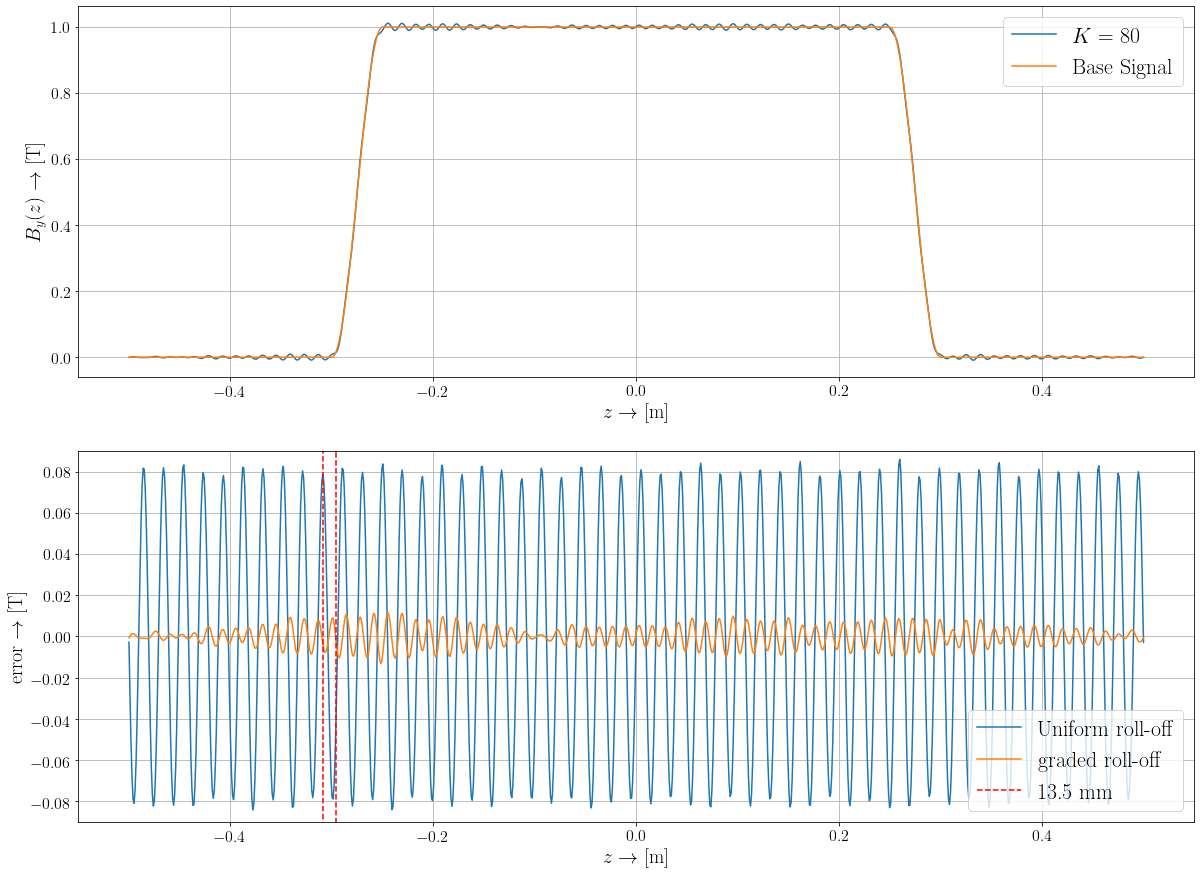

In [30]:
c_k,_,_,_  = np.linalg.lstsq(D, Phi_n, rcond=None)
By_rec = transform_to_spatial_domain(c_k,z,Z_0,Z_1)

error_g_1 = np.real(By_rec)-base_signal

%matplotlib inline

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(z,np.real(By_rec),label=r'$K = {}$'.format(80),linewidth=1.5)
ax2.plot(z,error_l,label=r'Uniform roll-off'.format(80),linewidth=1.5)
ax2.plot(z,error_g_1,label=r'graded roll-off'.format(80),linewidth=1.5)



ax1.plot(z,base_signal,label='Base Signal',linewidth=1.5)
ax1.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax1.set_ylabel(r'$B_y(z) \rightarrow$ [T]',fontsize=20)
ax1.legend()

l_min = 0.0135


vzpos = -0.309
ax2.plot([vzpos,vzpos,vzpos+l_min,vzpos+l_min],[-100,100,100,-100],'--',color='red',label='13.5 mm')
ax2.set_ylim((-0.09,0.09))
ax2.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax2.set_ylabel(r'error $\rightarrow$ [T]',fontsize=20)
ax2.legend()

We could decrease the absolute error by an order of magnitude. There is still an oscillation of $f \sim 1/13.5$ 1/mm remaining.<br>
Where does this come from?<br>
Surprisingly, the 8th turn of the coil has a similar length of:

In [31]:
print('Length 8th turn = {}'.format(lens_g[7]))

Length 8th turn = 0.013348388671875001


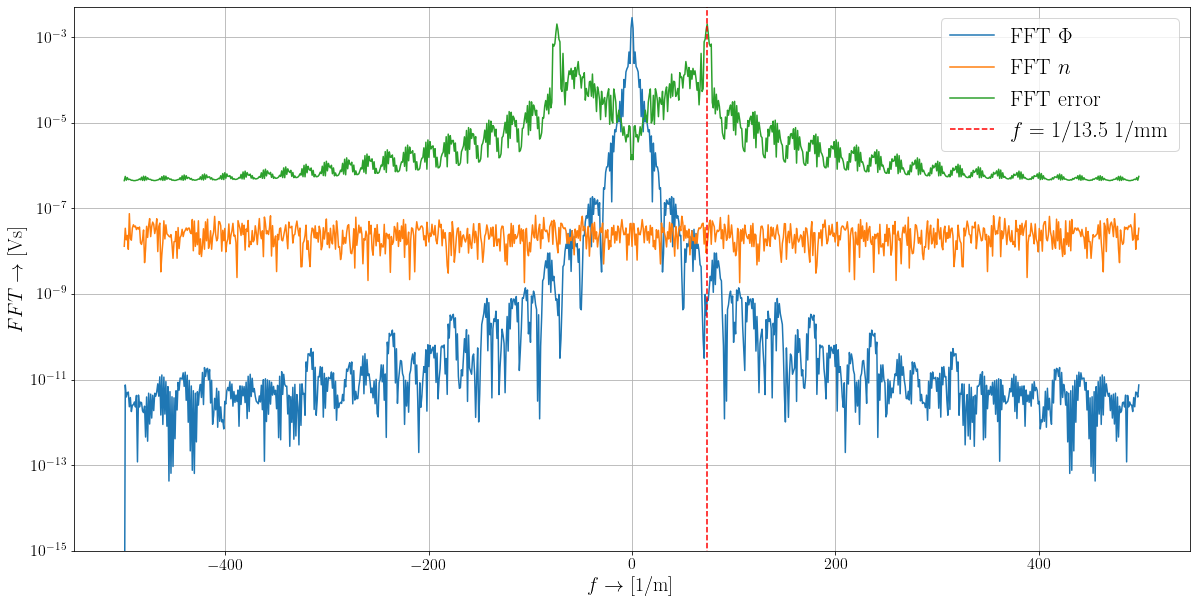

In [83]:
F_Phi = np.fft.fft(Phi)/len(Phi)
F_N = np.fft.fft(Phi_n-Phi)/len(Phi)
F_error = np.fft.fft(error_g_1)/len(Phi)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(np.fft.fftshift(np.fft.fftfreq(len(base_signal),dz)),np.fft.fftshift(abs(F_Phi)),label='FFT $\Phi$',linewidth=1.5)
ax.plot(np.fft.fftshift(np.fft.fftfreq(len(base_signal),dz)),np.fft.fftshift(abs(F_N)),label='FFT $n$',linewidth=1.5)
ax.plot(np.fft.fftshift(np.fft.fftfreq(len(base_signal),dz)),np.fft.fftshift(abs(F_error)),label='FFT error',linewidth=1.5)
ax.plot([1/0.0135,1/0.0135],[0,10],'--',color='red',label='$f = 1/13.5$ 1/mm')
ax.set_ylim((1e-15,5e-3))
ax.set_xlabel(r'$f\rightarrow$ [1/m]',fontsize=20)
ax.set_ylabel(r'$FFT \rightarrow$ [Vs]',fontsize=20)
ax.set_yscale('log')
ax.legend()

We now vary the roll-off factor $p < 1$, which was $3/4$ previously, in our coil design:
$$
l_{i+1} = p l_i 
$$

In [95]:
num_p = 7

p = np.linspace(0.2,0.8,num_p)
K_array = np.int32(np.linspace(5,max_K))

cond_container_p = np.zeros((len(K_array),num_p))


for i,pp in enumerate(p):
    
    lens_p = np.array([pp**k*l_0 for k in range(num_turns)])
    coil_p = Coil(radius,1,lens_p,widths_g,np.ones(widths_g.shape))
    
    for j,KK in enumerate(K_array):

        D = coil_p.assemble_D_fluxmeter_fourier_univariate(z,KK)
        cond_container_p[j,i] = np.linalg.cond(D)


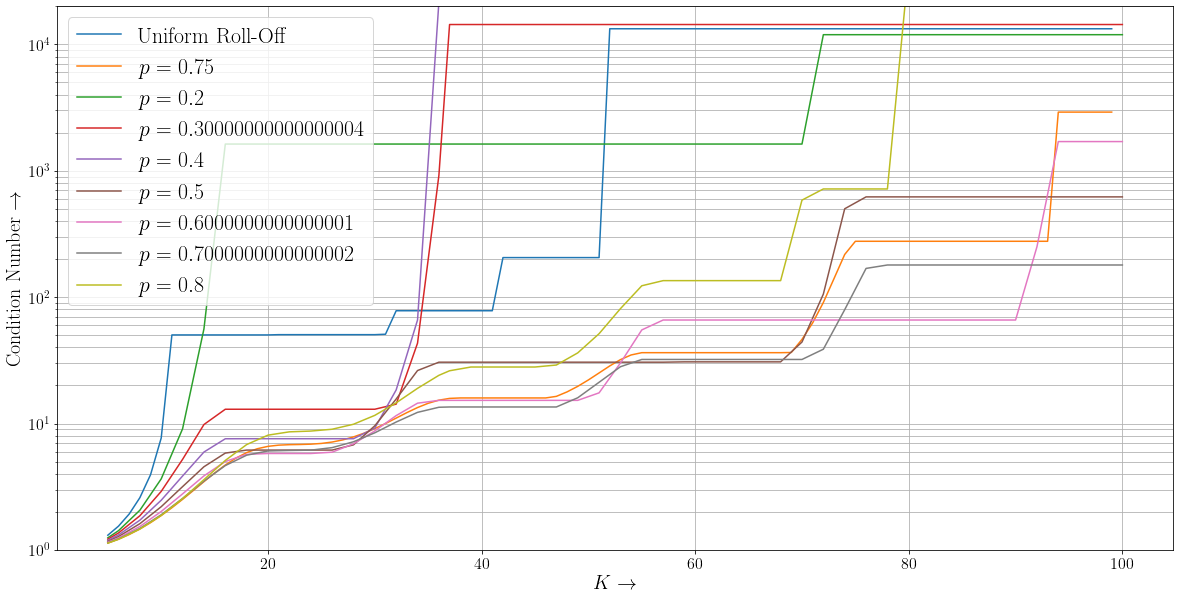

In [99]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(cond_container_l[:,0],cond_container_l[:,1],label='Uniform Roll-Off',linewidth=1.5)
ax.plot(cond_container_g[:,0],cond_container_g[:,1],label='$p = {}$'.format(3/4),linewidth=1.5)
for i,pp in enumerate(p):
    #print(K_array.shape)
    #print(cond_container_p[:,i].shape)    
    ax.plot(K_array,cond_container_p[:,i],label='$p = {}$'.format(pp),linewidth=1.5)
    
ax.set_xlabel(r'$K\rightarrow$',fontsize=20)
ax.set_ylabel(r'Condition Number $\rightarrow$',fontsize=20)
ax.set_yscale('log')
ax.set_ylim((1,2e4))
ax.legend()

$0.7$ seems to be a good candidate!

We now look at the factor $p$ between $0.62$ and $0.72$.

In [102]:
num_p = 7

p = np.linspace(0.62,0.72,num_p)
K_array = np.int32(np.linspace(5,max_K))

cond_container_p = np.zeros((len(K_array),num_p))


for i,pp in enumerate(p):
    
    lens_p = np.array([pp**k*l_0 for k in range(num_turns)])
    coil_p = Coil(radius,1,lens_p,widths_g,np.ones(widths_g.shape))
    
    for j,KK in enumerate(K_array):

        D = coil_p.assemble_D_fluxmeter_fourier_univariate(z,KK)
        cond_container_p[j,i] = np.linalg.cond(D)


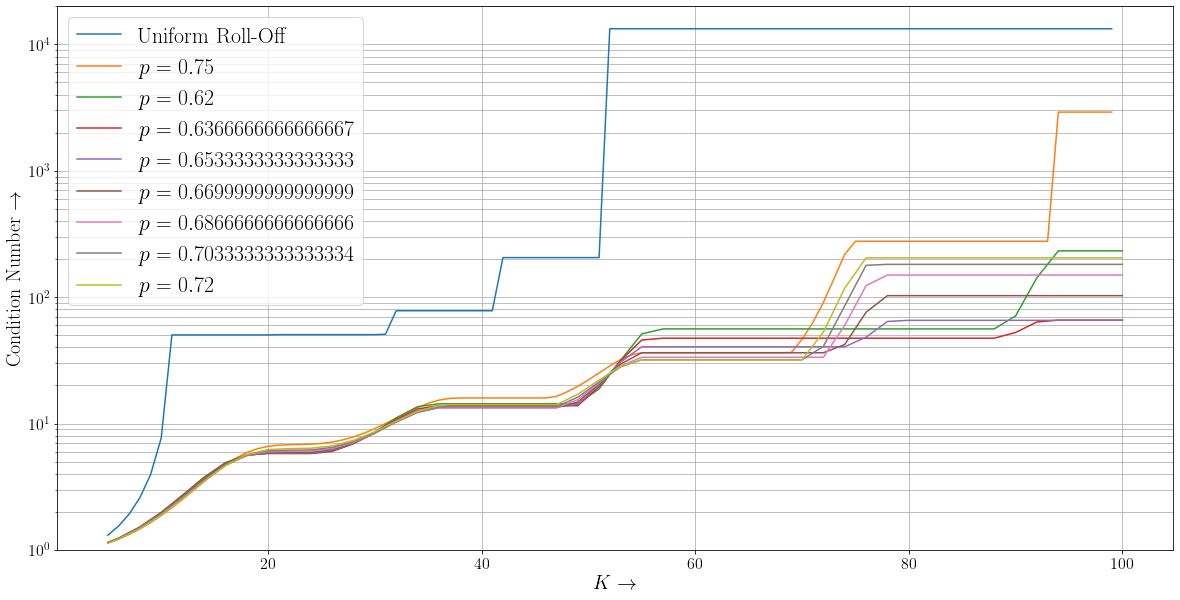

In [103]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(cond_container_l[:,0],cond_container_l[:,1],label='Uniform Roll-Off',linewidth=1.5)
ax.plot(cond_container_g[:,0],cond_container_g[:,1],label='$p = {}$'.format(3/4),linewidth=1.5)
for i,pp in enumerate(p):
    #print(K_array.shape)
    #print(cond_container_p[:,i].shape)    
    ax.plot(K_array,cond_container_p[:,i],label='$p = {}$'.format(pp),linewidth=1.5)
    
ax.set_xlabel(r'$K\rightarrow$',fontsize=20)
ax.set_ylabel(r'Condition Number $\rightarrow$',fontsize=20)
ax.set_yscale('log')
ax.set_ylim((1,2e4))
ax.legend()

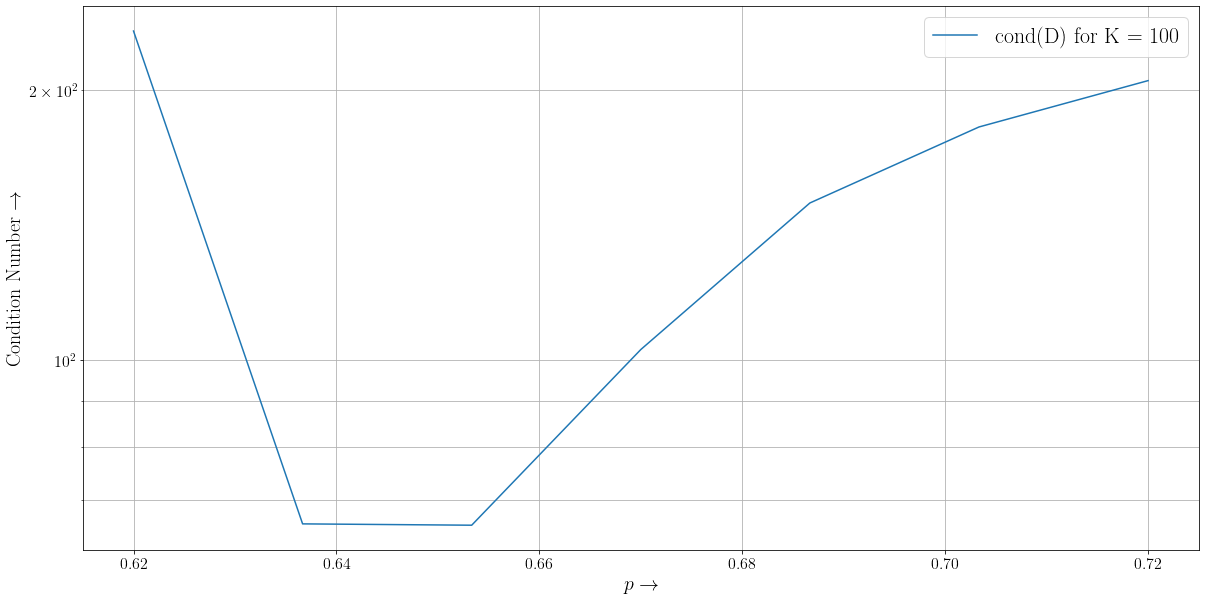

In [105]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(p,cond_container_p[-1,:],label='cond(D) for K = 100',linewidth=1.5)
ax.set_xlabel(r'$p\rightarrow$',fontsize=20)
ax.set_ylabel(r'Condition Number $\rightarrow$',fontsize=20)
ax.set_yscale('log')
ax.legend()

We will thus go for $p=0.65$!

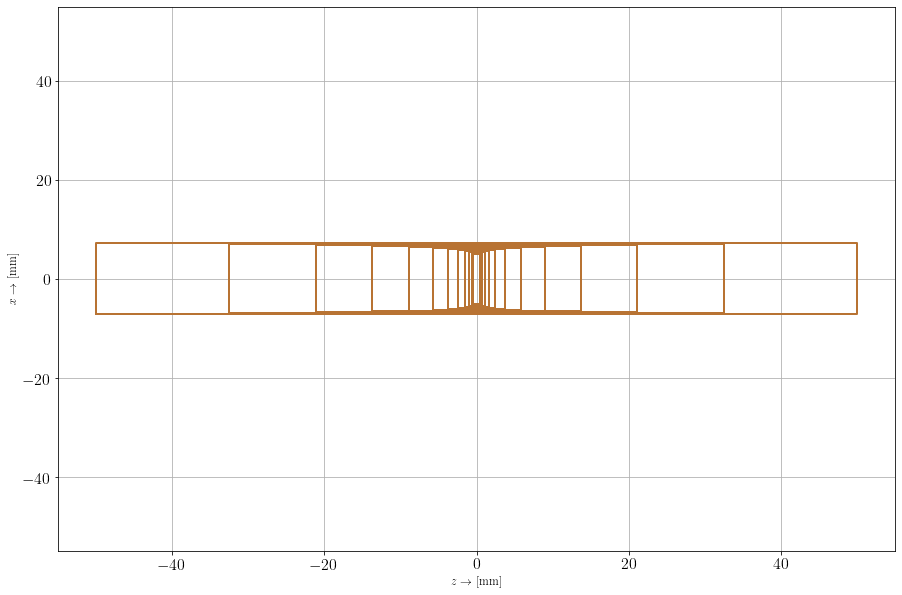

In [106]:
lens_o = np.array([(0.65)**k*l_0 for k in range(num_turns)])

coil_o = Coil(radius,1,lens_o,widths_g,np.ones(widths_g.shape))
coil_o.plot_layout()

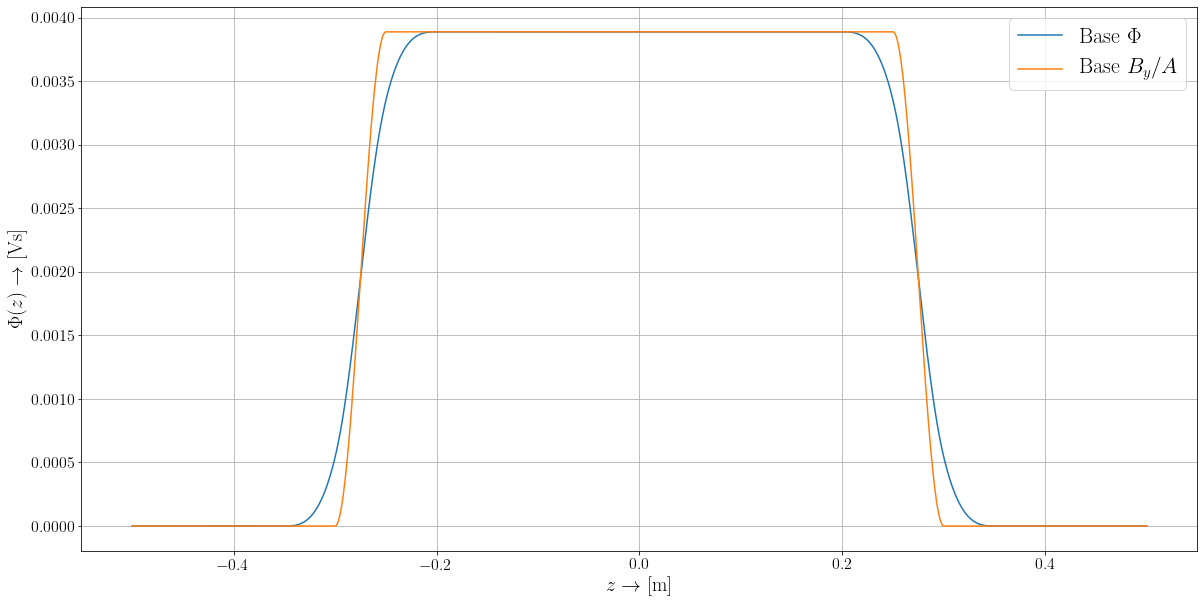

In [107]:
Phi = coil_o.integrate_z(By_fcn,z)
Phi_approx = base_signal*coil_o.compute_kn(1)


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(z,Phi,label='Base $\Phi$',linewidth=1.5)
ax.plot(z,Phi_approx,label='Base $B_y/A$',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()

sigma = 9.176960000000002e-07 Vs


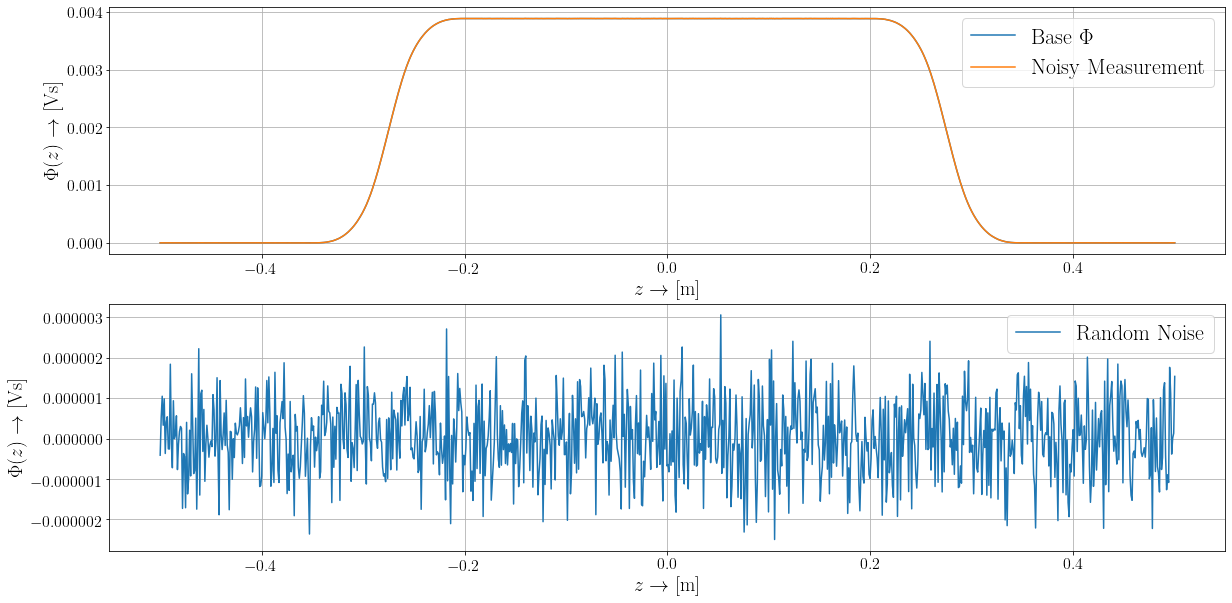

In [108]:
Phi_n = Phi + sigma*np.random.randn(Phi.shape[0])

print('sigma = {} Vs'.format(sigma))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.plot(z,Phi,label='Base $\Phi$',linewidth=1.5)
ax.plot(z,Phi_n,label='Noisy Measurement',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()
ax = fig.add_subplot(2,1,2)
ax.plot(z,Phi_n-Phi,label='Random Noise',linewidth=1.5)
ax.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax.set_ylabel(r'$\Phi(z) \rightarrow$ [Vs]',fontsize=20)
ax.legend()

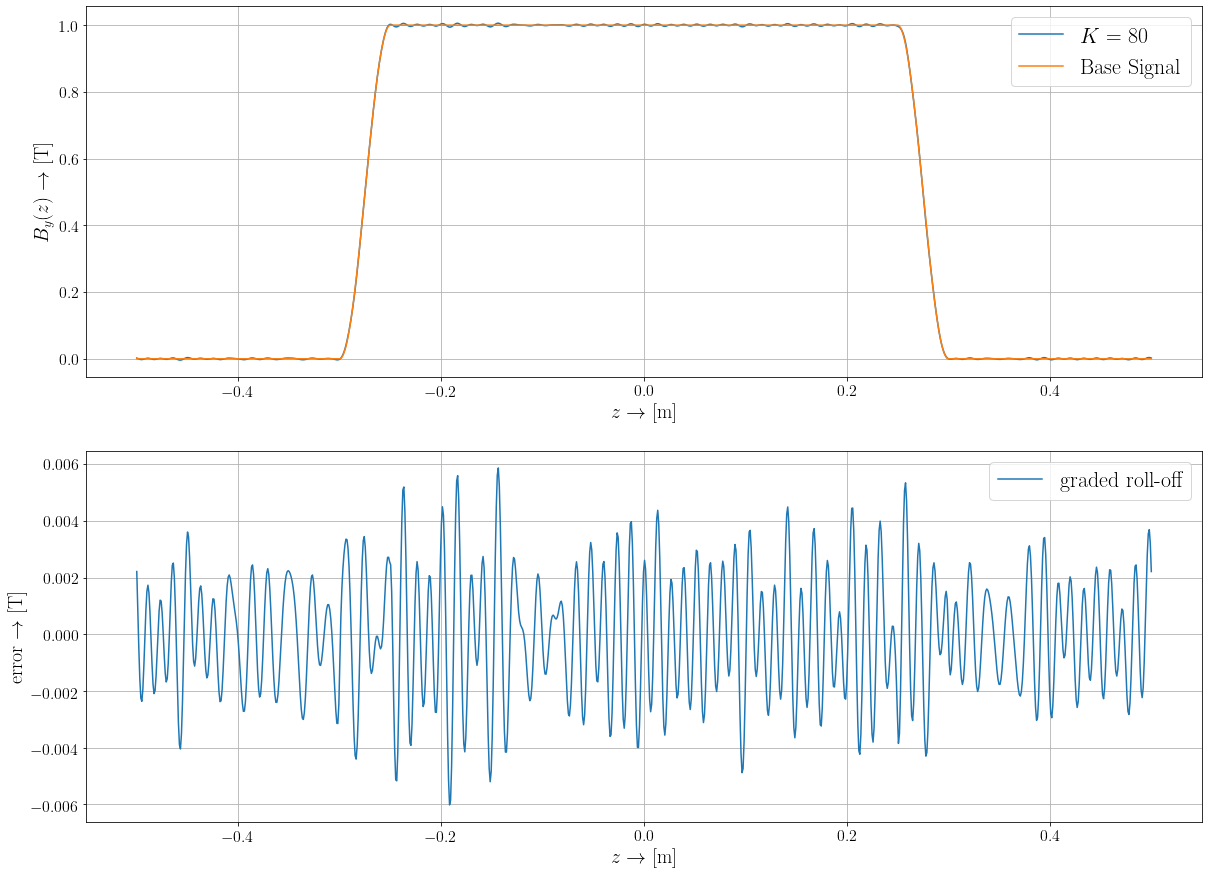

In [110]:
D = coil_o.assemble_D_fluxmeter_fourier_univariate(z,80)

c_k,_,_,_  = np.linalg.lstsq(D, Phi_n, rcond=None)
By_rec = transform_to_spatial_domain(c_k,z,Z_0,Z_1)

error_g_o = np.real(By_rec)-base_signal

%matplotlib inline

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(z,np.real(By_rec),label=r'$K = {}$'.format(80),linewidth=1.5)
#ax2.plot(z,error_l,label=r'Uniform roll-off'.format(80),linewidth=1.5)
ax2.plot(z,error_g_o,label=r'graded roll-off'.format(80),linewidth=1.5)



ax1.plot(z,base_signal,label='Base Signal',linewidth=1.5)
ax1.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax1.set_ylabel(r'$B_y(z) \rightarrow$ [T]',fontsize=20)
ax1.legend()

l_min = 0.0135


vzpos = -0.309
#ax2.plot([vzpos,vzpos,vzpos+l_min,vzpos+l_min],[-100,100,100,-100],'--',color='red',label='13.5 mm')
#ax2.set_ylim((-0.09,0.09))
ax2.set_xlabel(r'$z\rightarrow$ [m]',fontsize=20)
ax2.set_ylabel(r'error $\rightarrow$ [T]',fontsize=20)
ax2.legend()

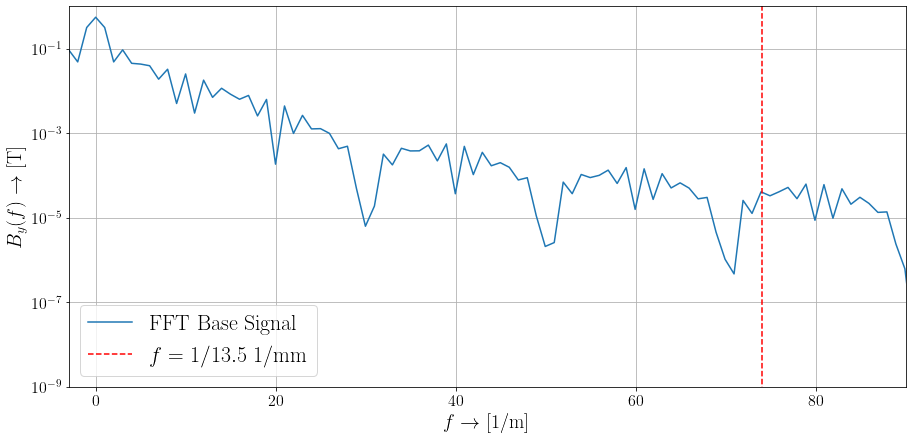

In [32]:
%matplotlib inline


fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.plot(np.fft.fftshift(np.fft.fftfreq(len(base_signal),dz)),np.fft.fftshift(abs(fft_base)),label='FFT Base Signal',linewidth=1.5)
ax.plot([1/0.0135,1/0.0135],[0,10],'--',color='red',label='$f = 1/13.5$ 1/mm')
ax.set_xlabel(r'$f\rightarrow$ [1/m]',fontsize=20)
ax.set_ylabel(r'$B_y(f) \rightarrow$ [T]',fontsize=20)
ax.set_ylim((1e-9,1))
ax.set_xlim((-3,90))
ax.set_yscale('log')
ax.legend()

In [65]:
u, s, vh = np.linalg.svd(D)

#print(s)

In [66]:
print(vh.shape)

(159, 159)


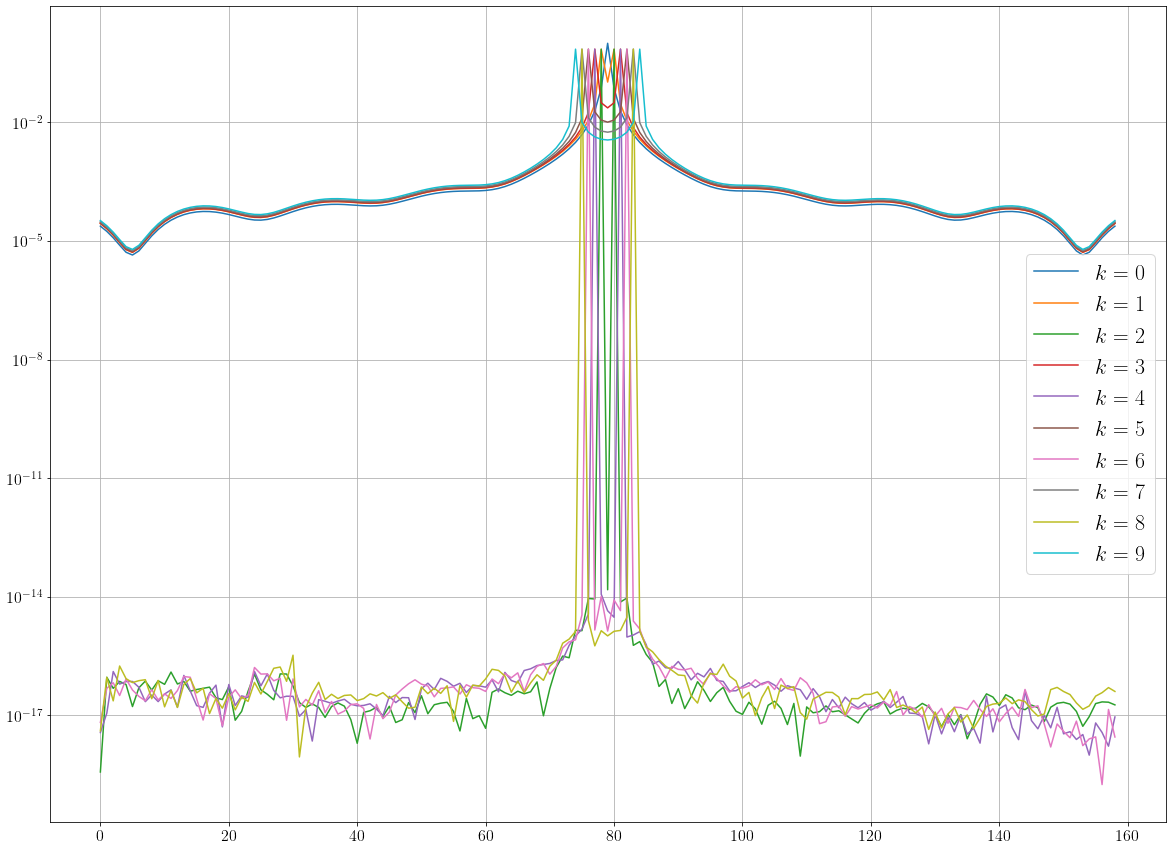

In [67]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(1,1,1)
for k in range(0,10,1):
    ax.plot(abs(vh[k,:]),linewidth=1.5,label='$k = {}$'.format(k))
    
ax.set_yscale('log')
ax.legend()

$$
\mathbf{D}^*\mathbf{D}\mathbf{c} = \mathbf{D}^*\left( \pmb{\Phi}+\pmb{\epsilon}\right)
$$

$$
\mathbf{D} = \mathbf{U}\pmb{\Sigma}\mathbf{V}^*
$$

$$
\left(\mathbf{U}\pmb{\Sigma}\mathbf{V}^*\right)^*\mathbf{U}\pmb{\Sigma}\mathbf{V}^*\mathbf{c} = \left(\mathbf{U}\pmb{\Sigma}\mathbf{V}^*\right)^*\left( \pmb{\Phi}+\pmb{\epsilon}\right)
$$

$$
\mathbf{V}\pmb{\Sigma}^T\mathbf{U}^*\mathbf{U}\pmb{\Sigma}\mathbf{V}^*\mathbf{c} = \mathbf{V}\pmb{\Sigma}^T\mathbf{U}^*\left( \pmb{\Phi}+\pmb{\epsilon}\right)
$$

$$
\mathbf{V}\pmb{\Sigma}^T\pmb{\Sigma}\mathbf{V}^*\mathbf{c} = \mathbf{V}\pmb{\Sigma}^T\mathbf{U}^*\left( \pmb{\Phi}+\pmb{\epsilon}\right)
$$